```
conda create -n py27 python=2.7 anaconda
source activate py27
conda install -c Quantopian zipline
QUANDL_API_KEY=<API KEY> zipline ingest -b quandl # this takes hours but you only do this once forever
conda install networkx==1.9.1   # conda zipline version doesn't enforce this
conda install -c cvxgrp cvxpy libgcc
pip install git+https://github.com/quantopian/alphalens
jupyter notebook
```

In [1]:
from __future__ import print_function

import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Define Universe


In [3]:
from research_tools import run_pipeline, get_symbols, get_pricing
from zipline.pipeline.factors import Returns, AverageDollarVolume
from zipline.pipeline import Pipeline

universe = AverageDollarVolume(window_length=120).top(500)

# a pipeline screen controls what is returned **not** what is calculated; a mask controls what is calculated
p = Pipeline(screen=universe)


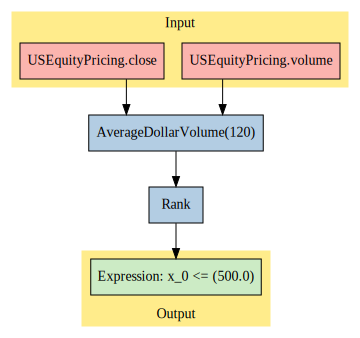

In [4]:
p.show_graph()

We will get this just for one day.

In [5]:
start_date = '2016-01-05'  # must be a valid trading day
end_date = '2016-01-05'    # must be a valid trading day

In [6]:
start = time.time()
df = run_pipeline(p, start_date, end_date)
end = time.time()
print('Compute time (s): %f' % (end-start))

Compute time (s): 5.427618


In [7]:
df.shape

(500, 0)

In [8]:
tickers = df.index.get_level_values(1).values.tolist()
tickers[0:10]

[Equity(0 [AAPL]),
 Equity(2 [ABBV]),
 Equity(3 [ABC]),
 Equity(4 [ABT]),
 Equity(5 [ACE]),
 Equity(6 [ACN]),
 Equity(7 [AGN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM])]

# 2. Get Data

In [9]:
dat = get_pricing(tickers, start_date='2011-01-05', end_date='2016-01-05')

In [10]:
dat.head()

,Equity(0 [AAPL]),Equity(2 [ABBV]),Equity(3 [ABC]),Equity(4 [ABT]),Equity(5 [ACE]),Equity(6 [ACN]),Equity(7 [AGN]),Equity(8 [ADBE]),Equity(9 [ADI]),Equity(10 [ADM]),...,Equity(3166 [PGR]),Equity(3168 [ZBH]),Equity(3169 [BXLT]),Equity(3171 [PYPL]),Equity(3172 [KHC]),Equity(3173 [WRK]),Equity(3175 [SYF]),Equity(3178 [CFG]),Equity(3183 [ARNC]),Equity(3185 [UAA])
2011-01-06 00:00:00+00:00,44.392,NaN,32.446,19.954,54.701,43.285,51.709,32.270,32.770,28.316,...,16.550,50.644,NaN,NaN,NaN,NaN,NaN,NaN,15.497,13.660
2011-01-07 00:00:00+00:00,44.709,NaN,32.511,20.037,54.293,43.357,52.518,32.040,32.579,28.548,...,16.376,50.636,NaN,NaN,NaN,NaN,NaN,NaN,15.554,13.388
2011-01-10 00:00:00+00:00,45.552,NaN,32.325,19.859,53.584,42.973,53.346,32.960,32.675,28.673,...,16.011,51.030,NaN,NaN,NaN,NaN,NaN,NaN,15.620,13.805
2011-01-11 00:00:00+00:00,45.444,NaN,32.641,19.817,53.832,43.562,52.657,32.980,32.961,28.780,...,15.986,52.849,NaN,NaN,NaN,NaN,NaN,NaN,15.468,13.598
2011-01-12 00:00:00+00:00,45.813,NaN,32.446,19.893,53.930,44.562,51.979,33.572,32.969,29.093,...,15.952,53.630,NaN,NaN,NaN,NaN,NaN,NaN,15.382,13.755


In [11]:
rets = dat.pct_change()[1:].fillna(0)
n_pos = len(rets.columns)

In [12]:
rets.head()

,Equity(0 [AAPL]),Equity(2 [ABBV]),Equity(3 [ABC]),Equity(4 [ABT]),Equity(5 [ACE]),Equity(6 [ACN]),Equity(7 [AGN]),Equity(8 [ADBE]),Equity(9 [ADI]),Equity(10 [ADM]),...,Equity(3166 [PGR]),Equity(3168 [ZBH]),Equity(3169 [BXLT]),Equity(3171 [PYPL]),Equity(3172 [KHC]),Equity(3173 [WRK]),Equity(3175 [SYF]),Equity(3178 [CFG]),Equity(3183 [ARNC]),Equity(3185 [UAA])
2011-01-07 00:00:00+00:00,0.007141,0.0,0.002003,0.004160,-0.007459,0.001663,0.015645,-0.007127,-0.005829,0.008193,...,-0.010514,-0.000158,0.0,0.0,0.0,0.0,0.0,0.0,0.003678,-0.019912
2011-01-10 00:00:00+00:00,0.018855,0.0,-0.005721,-0.008884,-0.013059,-0.008857,0.015766,0.028714,0.002947,0.004379,...,-0.022289,0.007781,0.0,0.0,0.0,0.0,0.0,0.0,0.004243,0.031147
2011-01-11 00:00:00+00:00,-0.002371,0.0,0.009776,-0.002115,0.004628,0.013706,-0.012916,0.000607,0.008753,0.003732,...,-0.001561,0.035646,0.0,0.0,0.0,0.0,0.0,0.0,-0.009731,-0.014995
2011-01-12 00:00:00+00:00,0.008120,0.0,-0.005974,0.003835,0.001820,0.022956,-0.012876,0.017950,0.000243,0.010876,...,-0.002127,0.014778,0.0,0.0,0.0,0.0,0.0,0.0,-0.005560,0.011546
2011-01-13 00:00:00+00:00,0.003667,0.0,0.014917,-0.004424,0.000315,-0.000381,0.004406,-0.005719,-0.004974,0.020589,...,-0.003636,-0.004680,0.0,0.0,0.0,0.0,0.0,0.0,-0.030100,0.008215


In [13]:
rets.shape

(1256, 500)

# 2. Create, Fit, and Test Statistical Risk Model

Fit a model with 20 latent risk factors. Return:
    - factor betas
    - factor covariance matrix
    - idiosyncratic variance matrix


In [14]:
from sklearn.decomposition import PCA

class RiskModelPCA():
    
    ANN_FACTOR = 252
    
    def __init__(self, num_factors):
        self._num_factors = num_factors
        self.num_stocks_ = None
        self.factor_betas_ = None
        self.factor_returns_ = None
        self.common_returns_ = None
        self.residuals_ = None
        self.factor_cov_matrix_ = None
        self.idio_var_matrix_ = None
        self.explained_variance_ratio_ = None

    def fit(self, returns):
        self.num_stocks_ = len(returns.columns)
        mod = PCA(n_components=self._num_factors, svd_solver='full')
        mod.fit(returns)
        
        self.factor_betas_ = pd.DataFrame(
            data=mod.components_.T,
            index=returns.columns
        )
        
        self.factor_returns_ = pd.DataFrame(
            data=mod.transform(rets),
            index=returns.index
        )
        
        self.explained_variance_ratio_ = mod.explained_variance_ratio_
        
        self.common_returns_ = pd.DataFrame(
            data=np.dot(self.factor_returns_, self.factor_betas_.T),
            index=returns.index
        )
        self.common_returns_.columns = returns.columns
        
        self.residuals_ = (returns - self.common_returns_)
        
        self.factor_cov_matrix_ = np.diag(
            self.factor_returns_.var(axis=0, ddof=1)*RiskModelPCA.ANN_FACTOR
        )
        
        self.idio_var_matrix_ = pd.DataFrame(
            data=np.diag(np.var(self.residuals_))*RiskModelPCA.ANN_FACTOR,
            index=returns.columns
        )
        
        self.idio_var_vector_ = pd.DataFrame(
            data=np.diag(self.idio_var_matrix_.values),
            index=returns.columns
        )
        
        self.idio_var_matrix_.columns = index=returns.columns

    def get_factor_exposures(self, weights):
        F = self.factor_betas_.loc[weights.index]
        return F.T.dot(weights)

    def predict(self, weights):
        """ Calculates expected portfolio risk as sqrt(h'XFX'h + h'Sh).
            This will fail if your portfolio has asset weights not in the risk model"""
        all_assets = pd.DataFrame(
            data=np.repeat(0, self.num_stocks_),
            index=self.factor_betas_.index)
        all_assets.loc[weights.index] = weights
        
            
        h = all_assets
        X = self.factor_betas_
        F = self.factor_cov_matrix_
        S = self.idio_var_matrix_
        
        return np.sqrt(h.T.dot(X).dot(F).dot(X.T).dot(h) + h.T.dot(S).dot(h))[0].values[0]


In [15]:
rm = RiskModelPCA(20)
rm.fit(rets)

### Plot The % of Variance Explained by Each Factor

You will see that the first factor dominates. The precise defintion of each factor in a latent model is unknown, however we can guess at the likely intepretation. What do you think is the best definition for this first factor?

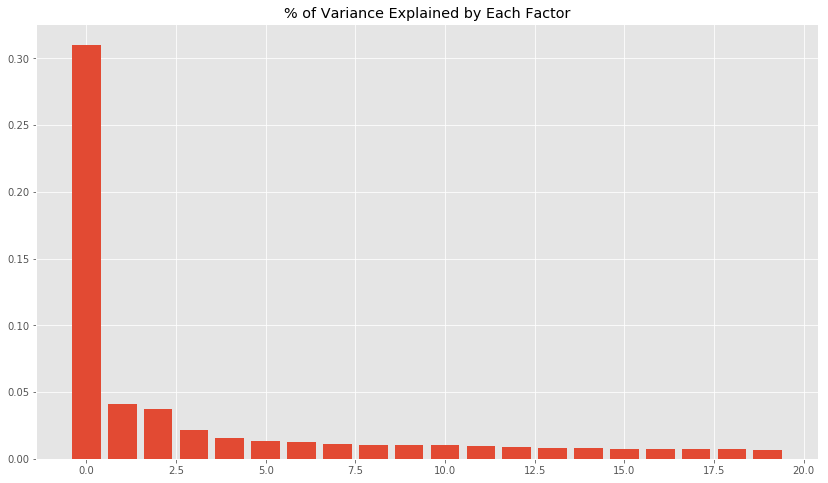

In [16]:
plt.bar(np.arange(20), rm.explained_variance_ratio_);
plt.title('% of Variance Explained by Each Factor');

### Plot Common Factor Returns

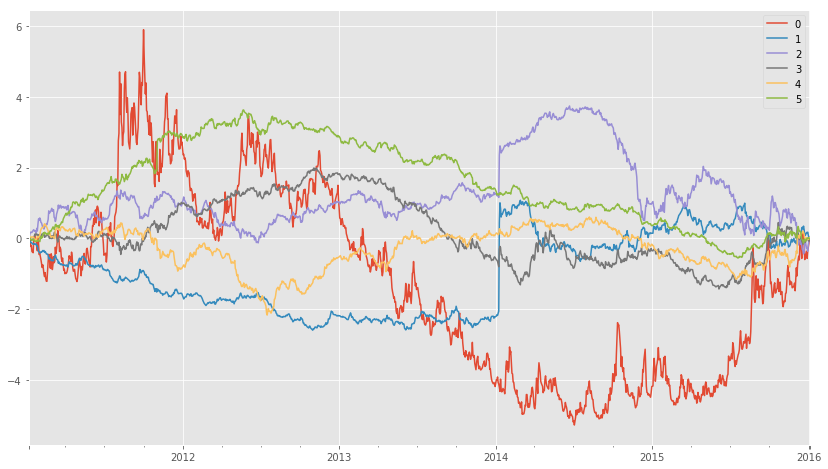

In [17]:
rm.factor_returns_.loc[:,0:5].cumsum().plot();

### Predict One Period Forward Portfolio Risk

In [18]:
sample_portfolio = [tickers[i] for i in np.random.choice(len(tickers), 4).tolist()]
sample_portfolio

[Equity(470 [WFC]), Equity(85 [CERN]), Equity(477 [WMT]), Equity(127 [DG])]

In [19]:
weights = pd.DataFrame(data=[0.25,0.25,0.25,0.25], index=sample_portfolio)

In [20]:
rm.predict(weights)

0.15989645488056634

# 3. Test Risk Model Prediction

In [61]:
# Pick random 20-day period
# Predict risk for each of 20 days; cumulate the predicted variance
# Run Risk-Ratio Statistic from Mahdavan paper p. 13
# np.sqrt(np.pi/2.0)*(1.0/T)*np.sum(s/fs)

# 4. Create Alpha Factor(s)

In [62]:
from ics_scheme import Sector
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import CustomFactor, SimpleMovingAverage

universe = AverageDollarVolume(window_length=120).top(500)
p = Pipeline(screen=universe)

# This is a momentum factor
# Hypothesis: higher past 12-month (252 days) returns are proportional to future return
factor_1 = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()).
    rank().
    zscore()
)

# This is a mean reversion factor
# Hypothesis: short-term outperformers(underperformers) compared to their sector will revert 
factor_2 = (
    -Returns(window_length=5, mask=universe).
    demean(groupby=Sector()).
    rank().
    zscore()
)

# This is a mean reversion factor
# Hypothesis: short-term outperformers(underperformers) to their sector will revert 
# With the addition that we smooth the factor output
factor_3 = (
    SimpleMovingAverage(inputs=[factor_2], window_length=5).
    rank().
    zscore()
)



class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    window_length=2

    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    # The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
    # As such, opens[-1] is the most recent open, and closes[0] is the earlier close
    
    def compute(self, today, assets, out, opens, closes):
        out[:] = (opens[-1] - closes[0]) / closes[0]

class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    window_length = 5
    
    inputs = [CTO(mask=universe)]
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)        

factor_4 = (
    TrailingOvernightReturns().
    rank().
    zscore()
)

factor_5 = (
    SimpleMovingAverage(inputs=[factor_4], window_length=5).
    rank().
    zscore()
)

        
p.add(factor_1, 'Momentum_1YR')
p.add(factor_2, 'Mean_Reversion_5Day_Sector_Neutral')
p.add(factor_3, 'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
p.add(factor_4, 'Overnight_Sentiment')
p.add(factor_5, 'Overnight_Sentiment_Smoothed')



It is best practice to inspect the DAG to ensure everything looks as you would expect:

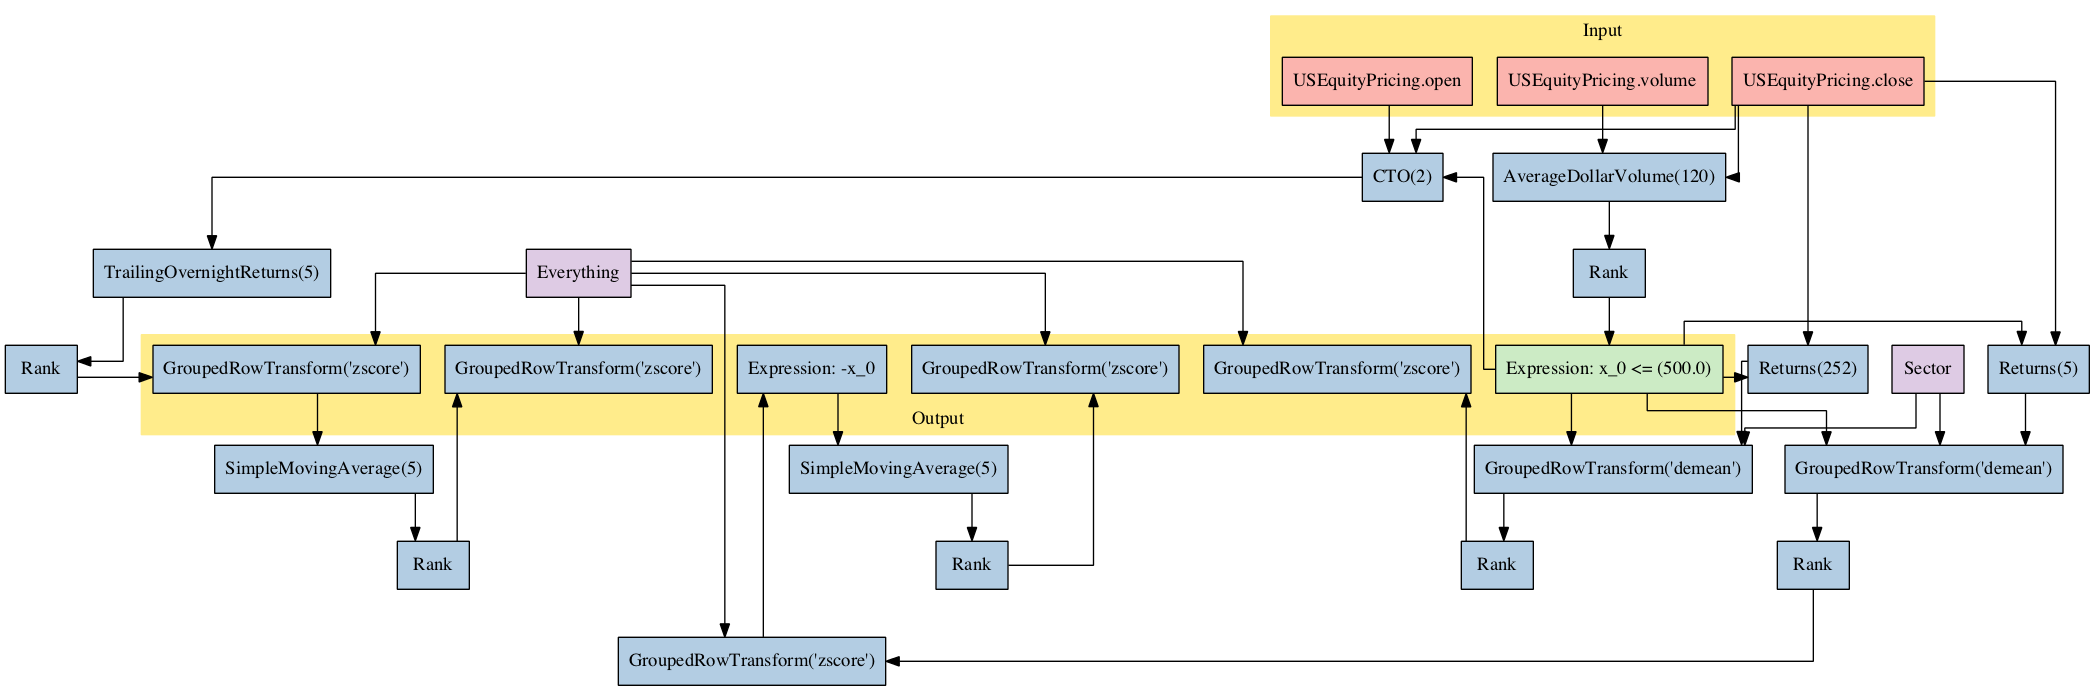

In [22]:
p.show_graph(format='png')

In [23]:
start_date = '2014-01-06'  # must be a valid trading day
end_date = '2016-01-05'    # must be a valid trading day

In [24]:
start = time.time()
df = run_pipeline(p, start_date, end_date)
end = time.time()
print('Compute time (s): %f' % (end-start))

Compute time (s): 8.439863


In [25]:
df.shape

(252000, 5)

In [26]:
df.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                            1.636523   
                          Equity(2 [ABBV])                            0.407054   
                          Equity(3 [ABC])                             0.847337   
                          Equity(4 [ABT])                            -0.805801   
                          Equity(5 [ACE])                                  NaN   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                                     1.454430   
                          Equity(2 [ABBV])                                     1.098074   
                          Equity(3 [ABC])                                      0.766580   
                          Equity(4 [ABT])                                      0.203040   
                          Equity(5 [ACE])                                           NaN   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])     -1.451747            -1.715737   
                          Equity(2 [ABBV])      0.924600            -1.658359   
                          Equity(3 [ABC])       0.866028             1.486222   
                          Equity(4 [ABT])      -0.924600             1.557102   
                          Equity(5 [ACE])            NaN            -1.522225   

                                            Overnight_Sentiment_Smoothed  
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                     -0.389275  
                          Equity(2 [ABBV])                      0.349898  
                          Equity(3 [ABC])                       1.526725  
                          Equity(4 [ABT])                       1.541351  
                          Equity(5 [ACE])                       0.246391

### Important: Date Alignment

When pipeline returns with a date of, e.g., `2016-01-07` this includes data that would be known as of before the **market open** on `2016-01-07`. As such, if you ask for `USEP.close.latest` it will return the closing price from the day before and label the date `2016-01-07`. All factor values assume to be run prior to the open on the labeled day with data known before that point in time.

In [27]:
df = df.dropna()
df.shape

(211614, 5)

In [28]:
df.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                            1.636523   
                          Equity(2 [ABBV])                            0.407054   
                          Equity(3 [ABC])                             0.847337   
                          Equity(4 [ABT])                            -0.805801   
                          Equity(6 [ACN])                             1.354077   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                                     1.454430   
                          Equity(2 [ABBV])                                     1.098074   
                          Equity(3 [ABC])                                      0.766580   
                          Equity(4 [ABT])                                      0.203040   
                          Equity(6 [ACN])                                      0.327350   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])     -1.451747            -1.715737   
                          Equity(2 [ABBV])      0.924600            -1.658359   
                          Equity(3 [ABC])       0.866028             1.486222   
                          Equity(4 [ABT])      -0.924600             1.557102   
                          Equity(6 [ACN])      -1.209092            -1.716862   

                                            Overnight_Sentiment_Smoothed  
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                     -0.389275  
                          Equity(2 [ABBV])                      0.349898  
                          Equity(3 [ABC])                       1.526725  
                          Equity(4 [ABT])                       1.541351  
                          Equity(6 [ACN])                      -1.729238

# 5. Evaluate Alpha Factors

In [29]:
import alphalens as al

In [30]:
assets = df.index.levels[1].values.tolist()

We need to get pricing data in order to calculate returns and factor returns. As stated above, the date labeled for the pipeline output is using data as of the day before (t-1). The pricing data we are getting uses the close price as of the labeled date (t). What this means in practice, is we will evaluate the alpha factor return as if we calculated the factor before the market open, but executed on it at that day's close. This is called a **delay 1** setting and is conservative.

In [31]:
pricing = get_pricing(
    assets,
    start_date,
    end_date,
    'close'
)

In [32]:
pricing.shape

(503, 664)

### Format alpha factors and pricing for `alphalens`

In [33]:
factor_names = df.columns
factor_data = {}

start_time = time.clock()
for factor in factor_names:
    print("Formatting factor data for: " + factor)
    factor_data[factor] = al.utils.get_clean_factor_and_forward_returns(
        factor=df[factor],
        prices=pricing,
        periods=[1]
    )
end_time = time.clock()
print("Time to get arrange factor data: %.2f secs" % (end_time - start_time))


Formatting factor data for: Mean_Reversion_5Day_Sector_Neutral
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Mean_Reversion_5Day_Sector_Neutral_Smoothed
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Momentum_1YR
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Overnight_Sentiment
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not ex

### Get the Factor-Weight Returns for each Alpha

Time to generate long/short returns: 2.72 secs


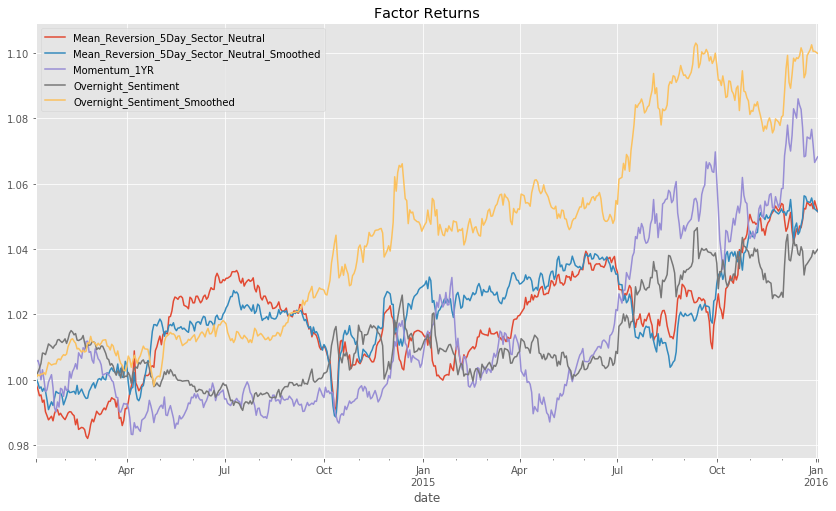

In [34]:
ls_factor_returns = []

start_time = time.clock()
for i, factor in enumerate(factor_names):
    ls = al.performance.factor_returns(factor_data[factor])
    ls.columns = [factor]
    ls_factor_returns.append(ls)
end_time = time.clock()
print("Time to generate long/short returns: %.2f secs" % (end_time - start_time))

df_ls_factor_returns = pd.concat(ls_factor_returns, axis=1)
(1+df_ls_factor_returns).cumprod().plot(title='Factor Returns');

Generally this looks ok... "up and to the right".

## Quantile Analysis

It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. 

In [35]:
qr_factor_returns = []

start_time = time.clock()
for i, factor in enumerate(factor_names):
    qr = al.performance.mean_return_by_quantile(factor_data[factor])
    qr[0].columns = [factor]
    qr_factor_returns.append(qr[0])
    #print(qr)
end_time = time.clock()
print("Time to generate quantile returns: %.2f secs" % (end_time - start_time))

df_qr_factor_returns = pd.concat(qr_factor_returns, axis=1)


Time to generate quantile returns: 3.21 secs


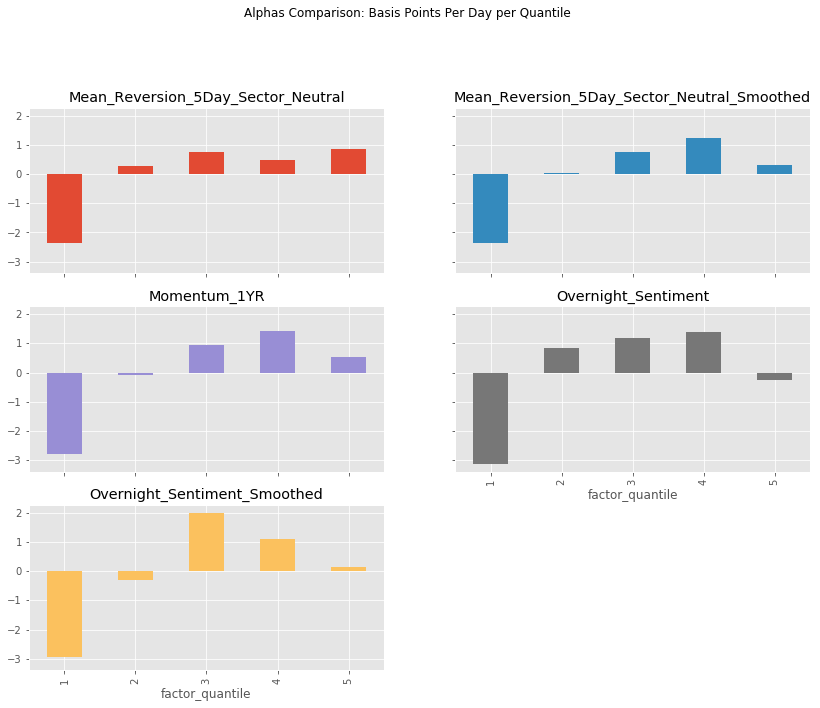

In [36]:
(10000*df_qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False,
    title='Alphas Comparison: Basis Points Per Day per Quantile'
);


What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas execpt MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, thats 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to acheive an attractive return.

### Calcuate the Sharpe Ratio of the Alphas

Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [38]:
print("Sharpe Ratio (Annualized; Entire Period)")
pd.DataFrame(data=16*df_ls_factor_returns.mean()/df_ls_factor_returns.std(), columns=['Sharpe Ratio']).round(2)

Sharpe Ratio (Annualized; Entire Period)


,Sharpe Ratio
Mean_Reversion_5Day_Sector_Neutral,0.78
Mean_Reversion_5Day_Sector_Neutral_Smoothed,0.78
Momentum_1YR,0.78
Overnight_Sentiment,0.58
Overnight_Sentiment_Smoothed,1.32


### Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always perfer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

In [39]:
ls_FRA = []

start_time = time.clock()
for i, factor in enumerate(factor_names):
    print("Calculating the FRA for: " + factor)
    ls = al.performance.factor_rank_autocorrelation(factor_data[factor]).to_frame()
    ls.columns = [factor]
    ls_FRA.append(ls)
end_time = time.clock()
print("Time to generate FRAs: %.2f secs" % (end_time - start_time))
df_ls_FRA = pd.concat(ls_FRA, axis=1)

Calculating the FRA for: Mean_Reversion_5Day_Sector_Neutral
Calculating the FRA for: Mean_Reversion_5Day_Sector_Neutral_Smoothed
Calculating the FRA for: Momentum_1YR
Calculating the FRA for: Overnight_Sentiment
Calculating the FRA for: Overnight_Sentiment_Smoothed
Time to generate FRAs: 2.65 secs


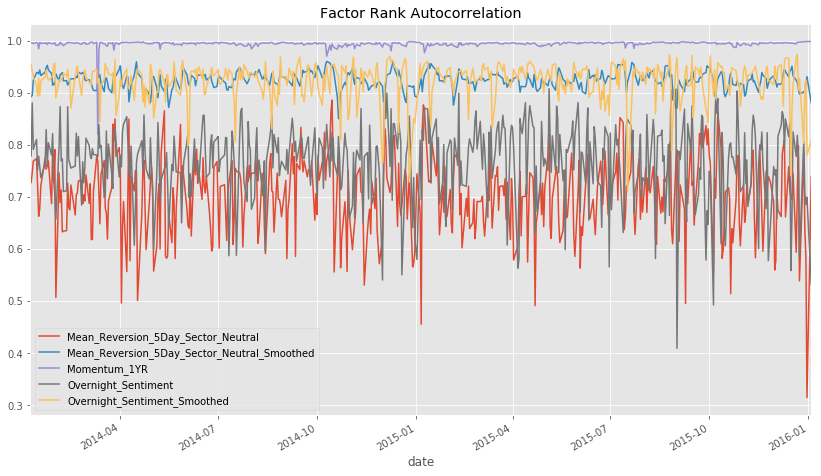

In [41]:
df_ls_FRA.plot(title="Factor Rank Autocorrelation");

### Very Important!

What do you notice about the comparision of the Sharpe Ratios, performance curves, and FRAs for the two mean reversion factors?

Answer: the Sharpe ratios and performance curves are almost identical, but the FRA is much higher for the "Smoothed" factor. This means that the smoothed factor will have much lower trading turnover in practice and is a much preferrable factor. The smoothing gives you a turnover reduction effectively for free.

What do you think would happen if we smooth the momentum factor?

Answer: the FRA is very close to 1.0 meaning the factor ranks are very stable. This makes sense since this factor is the trailing 12-month return; as one day passed, the cumulative 12-month return does not change much. As such, we should not expect any increase in FRA nor any improvement in the factor.

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [42]:
selected_factors = factor_names[[1, 2, 4]]
print(selected_factors)

Index([u'Mean_Reversion_5Day_Sector_Neutral_Smoothed', u'Momentum_1YR',
       u'Overnight_Sentiment_Smoothed'],
      dtype='object')


In [43]:
df['alpha_vector'] = df[selected_factors].mean(axis=1)

In [44]:
df.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                            1.636523   
                          Equity(2 [ABBV])                            0.407054   
                          Equity(3 [ABC])                             0.847337   
                          Equity(4 [ABT])                            -0.805801   
                          Equity(6 [ACN])                             1.354077   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                                     1.454430   
                          Equity(2 [ABBV])                                     1.098074   
                          Equity(3 [ABC])                                      0.766580   
                          Equity(4 [ABT])                                      0.203040   
                          Equity(6 [ACN])                                      0.327350   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])     -1.451747            -1.715737   
                          Equity(2 [ABBV])      0.924600            -1.658359   
                          Equity(3 [ABC])       0.866028             1.486222   
                          Equity(4 [ABT])      -0.924600             1.557102   
                          Equity(6 [ACN])      -1.209092            -1.716862   

                                            Overnight_Sentiment_Smoothed  \
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])                     -0.389275   
                          Equity(2 [ABBV])                      0.349898   
                          Equity(3 [ABC])                       1.526725   
                          Equity(4 [ABT])                       1.541351   
                          Equity(6 [ACN])                      -1.729238   

                                            alpha_vector  
2014-01-06 00:00:00+00:00 Equity(0 [AAPL])     -0.128864  
                          Equity(2 [ABBV])      0.790857  
                          Equity(3 [ABC])       1.053111  
                          Equity(4 [ABT])       0.273264  
                          Equity(6 [ACN])      -0.870327

# Putting it All Together


In [45]:
alphas = df[['alpha_vector']]

Get the alpha vector for a single day.

In [46]:
alpha_vector = alphas.loc[df.index.get_level_values(0)[-1]]
alpha_vector.head()

,alpha_vector
Equity(0 [AAPL]),0.105119
Equity(2 [ABBV]),-0.779001
Equity(3 [ABC]),0.125879
Equity(4 [ABT]),-0.329996
Equity(6 [ACN]),-0.125503


# 5. Calculate Optimal Portfolio Constrained by Risk Model

You have an alpha model and a risk model. Generally you want to trade as close as possible to the alpha model but limiting your risk as measured by the risk model. Optimization can help here.

\begin{equation*}
\begin{aligned}
& \underset{h}{\text{maximize}}
& & \alpha^T h + \lambda\|h\|_2\\
& \text{subject to}
& & h^T XFX'h + h'Sh \leq b \\
&&& X^Th \preceq k_{\text{max}} \\
&&& X^Th \succeq k_{\text{min}} \\
&&& h^T\mathbb{1} = 0 \\
&&& \|h\|_1 \leq 1 \\
&&& h \succeq u_{\text{min}} \\
&&& h \preceq u_{\text{max}}, 
\end{aligned}
\end{equation*}


In this formulation, we find the holdings vector $h$ which maxmizes the alpha of the resulting portfolio, subject to a number of constraints. In the objective function, we also have a regularization term that penalizes concentrated portfolios.

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minumum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth costraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on indivudual holdings.


Another common formumation is to take a pre-defined target weighting $h^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints.

\begin{equation*}
\begin{aligned}
& \underset{h}{\text{minimize}}
& & \|h - h^*\|_2\\
& \text{subject to}
& & h^T XFX'h + h'Sh \leq b \\
&&& X^Th \preceq k_{\text{max}} \\
&&& X^Th \succeq k_{\text{min}} \\
&&& h^T\mathbb{1} = 0 \\
&&& \|h\|_1 \leq 1 \\
&&& h \succeq u_{\text{min}} \\
&&& h \preceq u_{\text{max}}, 
\end{aligned}
\end{equation*}


In [55]:
def find_optimal_holdings(
    alpha_vector,
    risk_model,
    risk_cap=0.05,
    factor_max=10.0,
    factor_min=-10.0,
    h_max=0.55,
    h_min=-0.55,
    lambda_reg=0.0,
    obj_max_alpha=True):
    
    # we need to be very careful to align the index of each item!
    try:
        F = rm.factor_betas_.loc[alpha_vector.index]
        X = rm.factor_cov_matrix_
        S = np.diag(rm.idio_var_vector_.loc[alpha_vector.index].values.flatten())
        if np.any(np.isnan(S)):
            raise
    except Exception as e:
        print("Error; likely alphas not in risk model: " + str(e))

    w = cvx.Variable(len(alpha_vector))
    f = F.values.T*w
    
    risk = cvx.quad_form(f, X) + cvx.quad_form(w, S)

    if obj_max_alpha:
        obj = cvx.Maximize(
            alpha_vector.values.flatten()*w - 
            lambda_reg*cvx.norm(w, 2)
        )
    else:
        # (a - a.mean)/sum(abs(a))
        h_star = (alpha_vector.values.flatten()-np.mean(alpha_vector.values.flatten())) \
            /np.sum(np.abs(alpha_vector.values.flatten()))
        obj = cvx.Minimize(cvx.norm(w-h_star, 2))

    constraints = [
        sum(cvx.abs(w)) <= 1.0,
        sum(w) == 0.0,
        w <= h_max,
        w >= h_min,
        risk <= risk_cap+risk_cap,
        F.values.T*w <= factor_max,
        F.values.T*w >= factor_min
    ]
    
    prob = cvx.Problem(obj, constraints)
    prob.solve(verbose=True, max_iters=500)

    optimal_weights = np.asarray(w.value).flatten()

    return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

In [56]:
optimal_weights = find_optimal_holdings(
    alpha_vector,
    rm
)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.829e-14  -2.241e+03  +2e+03  1e-03  4e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -3.476e-02  -1.864e+03  +2e+03  8e-04  3e-01  8e-01  1e+00  0.1817  6e-02   1  1  1 |  0  0
 2  -1.052e-01  -2.511e+01  +3e+01  1e-05  6e-03  1e-02  1e-02  0.9866  1e-04   1  1  1 |  0  0
 3  -2.676e-01  -4.159e+00  +4e+00  2e-06  1e-03  2e-03  2e-03  0.9418  1e-01   1  1  1 |  0  0
 4  -3.654e-01  -4.250e+00  +4e+00  2e-06  1e-03  2e-03  2e-03  0.0238  9e-01   1  1  1 |  0  0
 5  -1.117e+00  -3.051e+00  +2e+00  8e-07  6e-04  1e-03  1e-03  0.9234  5e-01   1  1  1 |  0  0
 6  -1.368e+00  -1.651e+00  +3e-01  1e-07  1e-04  2e-04  2e-04  0.8753  2e-02   1  1  1 |  0  0
 7  -1.419e+00  -1.541e+00  +1e-01  5e-08  4e-05  7e-05  7e-05  0.6760  2e-01   1  1  1 |  0  0
 8  -1.460e+00  -1.469e+00  +1e-02  4e-09  3e-

We ran an optimization with no constraints except for the leverge and net constraint. What did the optimizer do?

In [57]:
optimal_weights.loc[optimal_weights[0].abs()>0.00001]

,0
Equity(326 [NKE]),0.5
Equity(2849 [YELP]),-0.5


Yikes. It put all the weight in just two stocks. We can see that these two stocks have the max and min alpha respectively.

In [50]:
print(alpha_vector.loc[alpha_vector.alpha_vector==alpha_vector.alpha_vector.max()])
print(alpha_vector.loc[alpha_vector.alpha_vector==alpha_vector.alpha_vector.min()])


                   alpha_vector
Equity(326 [NKE])      1.473711
                     alpha_vector
Equity(2849 [YELP])     -1.453405


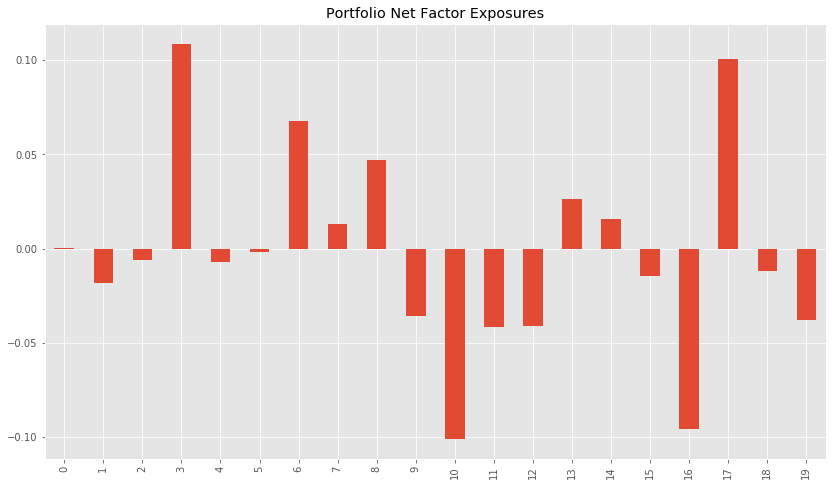

In [54]:
rm.get_factor_exposures(optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False
);

So in order to enforce diversification, we can do a number of things?

- add a portfolio risk cap constraint
- add a max and min position limit constraint
- add a max and min portfolio factor exposure constraint
- add regularization to the objective function

Question: Can we simply add a constraint that says "position count must be greater than N securities?"
Answer: This is an integer constraint and is not handled by convex optimizers.

So let's try two approaches:

### (1) add a regularization parameter

In [51]:
optimal_weights_1 = find_optimal_holdings(
    alpha_vector,
    rm,
    lambda_reg=5.0
)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.248e-14  -2.241e+03  +6e+03  1e-01  3e-02  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  -7.462e+01  -3.371e+02  +8e+02  1e-02  3e-03  4e-01  4e-01  0.9890  1e-01   2  2  2 |  0  0
 2  -6.618e+00  -2.829e+01  +7e+01  8e-04  2e-04  4e-02  4e-02  0.9352  3e-02   3  2  2 |  0  0
 3  -9.878e-01  -2.835e+00  +7e+00  7e-05  1e-05  2e-03  4e-03  0.9065  1e-03   5  4  4 |  0  0
 4  -4.813e-01  -9.181e-01  +2e+00  1e-05  2e-06  5e-04  1e-03  0.8311  1e-01   1  1  1 |  0  0
 5  -4.852e-01  -6.466e-01  +7e-01  6e-06  9e-07  2e-04  4e-04  0.7724  2e-01   2  2  2 |  0  0
 6  -4.522e-01  -4.856e-01  +1e-01  1e-06  2e-07  4e-05  8e-05  0.8384  5e-02   2  2  2 |  0  0
 7  -4.487e-01  -4.641e-01  +7e-02  5e-07  8e-08  1e-05  4e-05  0.9890  5e-01   2  2  2 |  0  0
 8  -4.467e-01  -4.483e-01  +7e-03  6e-08  9e-

/Users/jonathan/anaconda3/envs/alphalens/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


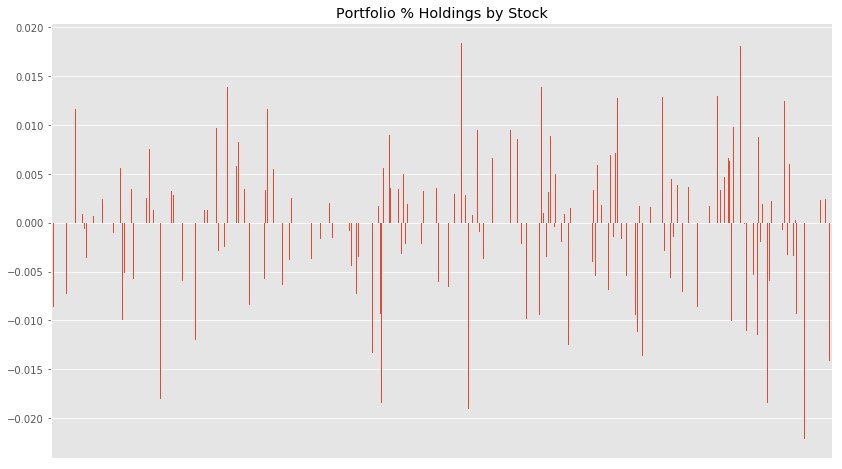

In [52]:
optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock');
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)


Nice. Well diversified. And we can also look at the net portfolio factor exposures:

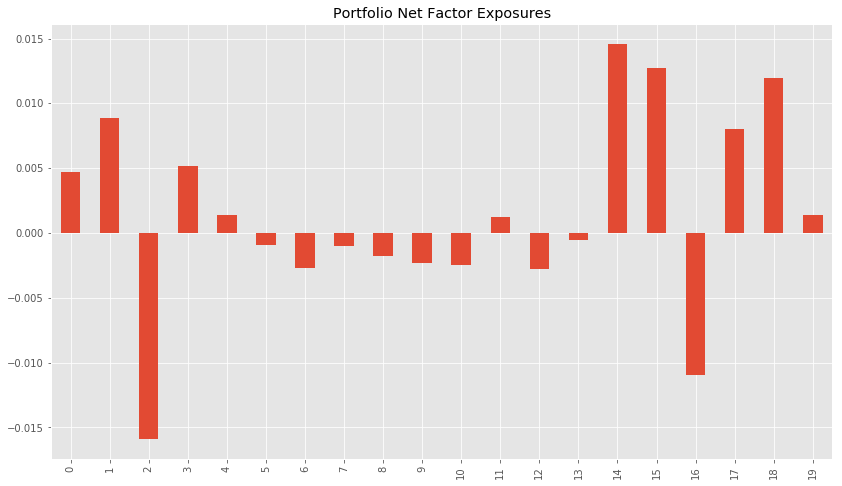

In [53]:
rm.get_factor_exposures(optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False
);

### (2) Add Strict Factor Constraints

In [58]:
optimal_weights_2 = find_optimal_holdings(
    alpha_vector,
    rm,
    h_max=0.02,
    h_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015,
    obj_max_alpha=False
)




ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.060e+01  +2e+03  1e+00  9e-02  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -1.651e+01  -1.898e+01  +3e+02  6e-01  1e-02  2e-01  1e-01  0.9890  1e-01   2  2  2 |  0  0
 2  -3.368e+00  -3.879e+00  +2e+02  1e-01  8e-04  4e-02  9e-02  0.5259  2e-01   3  2  3 |  0  0
 3  -3.388e-01  -3.952e-01  +3e+01  2e-02  5e-05  6e-03  2e-02  0.8554  9e-02   3  3  3 |  0  0
 4  -7.018e-02  -8.448e-02  +1e+01  4e-03  9e-06  1e-03  6e-03  0.7111  5e-02   4  5  5 |  0  0
 5  -6.420e-02  -7.221e-02  +6e+00  2e-03  4e-06  3e-04  3e-03  0.8346  5e-01   6  6  7 |  0  0
 6  -8.609e-03  -9.548e-03  +8e-01  2e-04  5e-07  4e-05  4e-04  0.8875  1e-02   1  1  1 |  0  0
 7  -1.533e-03  -1.698e-03  +1e-01  3e-05  8e-08  3e-06  8e-05  0.8933  9e-02   1  1  1 |  0  0
 8  -1.966e-04  -2.045e-04  +1e-02  2e-06  4e-

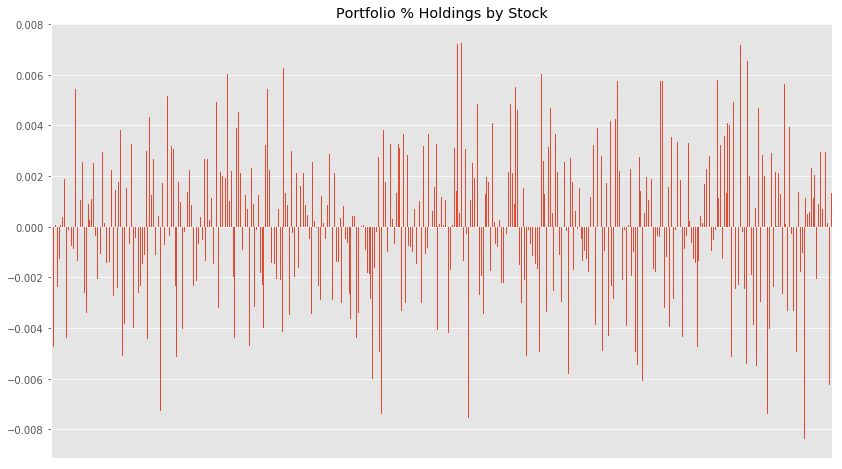

In [59]:
optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock');
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

How would you compare and constrast these two approaches?

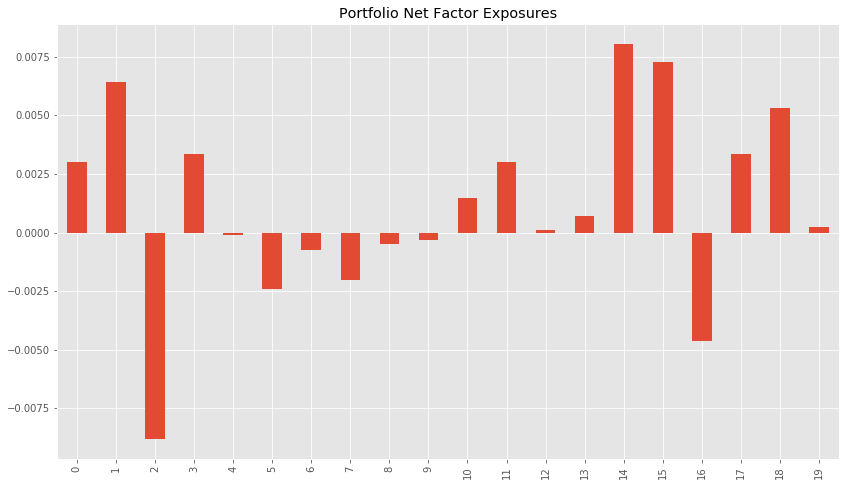

In [60]:
rm.get_factor_exposures(optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False
);